# E10-3: A multi-resolution sinusoidal model

In this exercise you will implement a multi-resolution sine model by modifying the `sineModel()` function. 

You have seen through several assignments that the choice of window size is an important tradeoff between time and frequency resolution. Longer windows have a better frequency resolution and can resolve two close sinusoids even at low frequencies, while smaller windows have a better time resolution leading to sharper onsets. So far, in all the analyses, we have only considered a single window length over the whole sound. As we know, analysis of signals with low frequency components needs longer windows as compared to signals with high frequency content. The optimal choice of window length is thus dependent on the frequency content of the signal. In other words, it is better to choose a longer window for the analysis of the low frequencies while a shorter window is sufficient for higher frequencies. In this exercise, you will explore the use of multiple window sizes for analysis in different frequency bands of the signals, what is called multi-resolution.

For each audio frame of `x` you should compute three different DFTs with three different window sizes and find the sinusoidal peaks for each of the DFTs. For example, you can choose window sizes `M1 = 4095, M2 = 2047, M3 = 1023`, to generate three windows w1, w2, w3. Choose N1, N2, N3 to be the power of two bigger than the corresponding window size. Then compute the spectra, `X1`, `X2`, and `X3` using `dftAnal()`. Define the frequency bands like `B1: 0 <= f < 1000Hz, B2: 1000 <= f < 5000, B3: 5000 <= f < 22050` and find the peaks of `B1` in `X1`, the ones of `B2` in `X2`, and the ones of `B3` in `X3`. From the peaks we finally re-synthesize the frame and generate the output `y`. 

Complete `sineModelMultiRes()`, by copiying and modifying the code from `SineModel()`. The functions should take as input three windows with different sizes, three FFT sizes, and the values for the frequency bands. Write the code to implement the multi-resolution analysis as described above.

Choose two different polyphonic recordings from freesound that have both a relevant melodic and percussion components. Edit them and change their format as needed. Choose suitable set of parameters for their analysis. Experiment with different window sizes and fruequency bands for the two sounds such that you get both crisp onsets and good frequency resolution. Get the best posible base line reconstruction with `SineModel()` and the best with `sineModelMultiRes()`. Listen the sounds and visualize the information that might be needed to undertand the process. 

Your explanation should include:

1. Freesound link to the two sounds chosen.
2. Explanation and justification of the band edges and the window sizes for each sound.
3. Observations about the advantages of a multi-resolution analysis (comment on the time-frequency resolution, computational complexity and extensions to HPR and HPS models).
4. Challenges you might face if you were to extend it to HPR and HPS models (mainly in sinusoid tracking and F0 estimation).
5. Further methods to improving the time-frequency resolution trade-off. 


In [1]:
import sys, os
from scipy.signal import get_window
import numpy as np
from scipy.signal import blackmanharris, triang
from scipy.fftpack import ifft, fftshift
import math
sys.path.append('../software/models/')
import dftModel as DFT
import utilFunctions as UF
import dftModel as DFT
import utilFunctions as UF
import sineModel as SM
import IPython.display as ipd

import matplotlib.pyplot as plt

In [2]:
def sineModelMultiRes(x, fs, w, N, t, B):
    """
    Analysis/synthesis of a sound using the sinusoidal model, without sine tracking
    Inputs:
        x: input array sound
        w: 3 analysis windows
        t: threshold in negative dB 
        B: 3 frequency boundaries
    Output:
        y: output array sound
    """

    ### your code here, start from copying the code from sineModel()
    N_min = np.min(N)
    N_max = np.max(N)
    H = N_min//4                                                    # Hop size used for analysis and synthesis
    hN = N_min//2
    hM1 = []
    hM2 = [] 
    wn = []
    pin= []
    
    for i in w:
        hM1 = np.append(hM1, math.floor((i.size+1)/2)).astype(int)  # half analysis window size by rounding
        hM2 = np.append(hM2, math.floor(i.size/2)).astype(int)      # half analysis window size by floor
        wn.append(i/sum(i))                                         # normalize analysis window
    x = np.append(np.zeros(N_max),x)                                # add zeros at beginning
    
    for i in range(len(N)):                                         # init pointers
        pin = np.append( pin, (N_max - hM2[i])).astype(int)
    pend = x.size - np.max(hM1)                                     # last sample to start a frame
    
    yw = np.zeros( N_min )                              # initialize output sound frame
    y = np.zeros(x.size)                                # initialize output array                           
    sw = np.zeros( N_min )                              # initialize synthesis window
    ow = triang(2*H)                                    # triangular window
    sw[hN-H:hN+H] = ow                                  # add triangular window
    bh = blackmanharris(N_min)                          # blackmanharris window
    bh = bh / sum(bh)                                   # normalized blackmanharris window
    sw[hN-H:hN+H] = sw[hN-H:hN+H] / bh[hN-H:hN+H]       # normalized synthesis window

    xmX = []                                            # Initialise empty list for mX
    
    while np.max(pin) < pend:                                       # while input sound pointer is within sound
        low_B = 0
        ipfreq_bands = []
        ipmag_bands = []
        ipphase_bands = []
        mX_bands = []
    #-----analysis-----  
        for p, h1, h2, w, n, high_B in zip(pin, hM1, hM2, wn, N, B):# CORE OF THE MULTI-RESOLUTION MODEL
            x1 = x[p-h1:p+h2]                                       # select frame
            mX, pX = DFT.dftAnal(x1, w, n)                          # compute dft
            ploc = UF.peakDetection(mX, t)                          # detect locations of peaks
            iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)     # refine peak values by interpolation
            ipfreq = fs*iploc/float(n)                              # convert peak locations to Hertz
            idxs = np.argwhere((ipfreq>low_B) & (ipfreq<high_B))    # peak indexes in the frequency band
            
            ipfreq_bands = np.append(ipfreq_bands, ipfreq[idxs])    # append interpolated frequency peaks
            ipmag_bands = np.append(ipmag_bands, ipmag[idxs])       # append magnitude of interpolated freq peaks
            ipphase_bands = np.append(ipphase_bands, ipphase[idxs]) # append phase of interpolated freq peaks
            
            low_Bb = int(low_B*float(n)/fs)                         # discrete low frequency boundary
            high_Bb = int(high_B*float(n)/fs)                       # discrete high frequency boundary
            mX_bands = np.concatenate((mX_bands, mX[low_Bb: high_Bb]), axis=None)
            
            low_B = high_B                                          # low frequency boundary
        xmX.append(np.array(mX_bands))                              # Append output to list
        
    #-----synthesis-----
        Y = UF.genSpecSines(ipfreq_bands, ipmag_bands, ipphase_bands, N_min, fs)   # generate sines in the spectrum         
        fftbuffer = np.real(ifft(Y))                             # compute inverse FFT
        yw[:hN-1] = fftbuffer[hN+1:]                             # undo zero-phase window
        yw[hN-1:] = fftbuffer[:hN+1] 
        y[np.min(pin)-hN:np.min(pin)+hN] += sw*yw                # overlap-add and apply a synthesis window
        pin += H                                                 # advance sound pointer
    return y, xmX

In [3]:
# test case 1 - https://freesound.org/people/antoinevg/sounds/369227/

# base line sinusoidal analysis/synthesis
### set the parameters
input_file = '../sounds/antoinevg__trance-loop.wav'
M = 1201
N = 2**np.ceil(np.log2(M)).astype(int) # power of 2 bigger than M
t = -80
window = 'blackman'

# no need to change code from here
fs, x = UF.wavread(input_file) 
w = get_window(window, M) 
y_baseline = SM.sineModel(x, fs, w, N, t)

# multiresolution sinusoidal analysis/synthesis
### set the parameters
M = [2001, 501, 201]
N = 2**np.ceil(np.log2(M)).astype(int) # power of 2 bigger than M
t = -80
B = [600, 3600, 22050]
window = ['hamming', 'hamming', 'blackman']

# get a window for each value M
w = []
for w_size, window_type in zip(M,window):
    w.append( get_window(window_type, w_size) )

# no need to change code from here
y , xmX = sineModelMultiRes(x, fs, w, N, t, B)

# playing the signals
print("Original")
ipd.display(ipd.Audio(data=x, rate=fs))

print("Base line sinusoidal synthesis")
ipd.display(ipd.Audio(data=y_baseline, rate=fs))

print("Multi-resolution sinusoidal analysis/synthesis")
ipd.display(ipd.Audio(data=y, rate=fs))

Original


Base line sinusoidal synthesis


Multi-resolution sinusoidal analysis/synthesis


In [4]:
# test case 2 - https://freesound.org/people/Dodgy%20C/sounds/179597/

# base line sinusoidal analysis/synthesis
### set the parameters
input_file = '../sounds/dodgy-c__dodgy-c-slowjamz-buildabeat-pt3-hook3.wav'
M = 1201
N = 2**np.ceil(np.log2(M)).astype(int) # power of 2 bigger than M
t = -80
window = 'hamming'

# no need to change code from here
fs, x = UF.wavread(input_file) 
w = get_window(window, M) 
y_baseline = SM.sineModel(x, fs, w, N, t)

# multiresolution sinusoidal analysis/synthesis
### set the parameters
M = [1501, 501, 201]
N = 2**np.ceil(np.log2(M)).astype(int) # power of 2 bigger than M
t = -80
B = [500, 4500, 22050]
window = ['hamming', 'hamming', 'blackman']

# get a window for each value M
w = []
for w_size, window_type in zip(M,window):
    w.append( get_window(window_type, w_size) )
fs, x = UF.wavread(input_file)

# no need to change code from here
y , xmX = sineModelMultiRes(x, fs, w, N, t, B)

# playing the signals
print("Original")
ipd.display(ipd.Audio(data=x, rate=fs))

print("Base line sinusoidal synthesis")
ipd.display(ipd.Audio(data=y_baseline, rate=fs))

print("Multi-resolution sinusoidal analysis/synthesis")
ipd.display(ipd.Audio(data=y, rate=fs))

//anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Original


Base line sinusoidal synthesis


Multi-resolution sinusoidal analysis/synthesis


## Your explanation

### Freesound links:
#### Test case 1: https://freesound.org/people/antoinevg/sounds/369227/
#### Test case 2: https://freesound.org/people/Dodgy%20C/sounds/179597/


### Explanation and justification of the band edges and the window sizes for each sound.
#### Test case 1:
`M = [2001, 501, 201]`

`window = ['hamming', 'hamming', 'blackman']`

`B = [600, 3600, 22050]`

##### Low: 
- Window size selected for resolving the lowest bass frequency. 
- The narrow main-lobe of the hamming window helps to have a better frequency resolution for resolving the frequencies of the bass and the electronic kick drum.
- Bandwidth containing the main harmonics of the bass.

##### Mid: 
- Window considerably shorter than that of the low band to capture the attack of the lower partials of the snare and the melodic synthetizers, but it is able to resolve the upper partials of the electronic kick drum.
- The narrow main-lobe of the hamming window helps to have a better frequency resolution for resolving the lower frequencies of the melodic synthetizers.
- Bandwidth containing the main partials of the snare and one of the melodic synthetizers.

##### High:
- Significantly short window to capture the attack of the fast-moving hit-hat, but it is able to resolve the upper partials of the snare and the melodic synthetizers.
- Blackman window met the frequency resolution requirements and helps refine the peak detection due to the low magnitude level of its side-lobes.
- Bandwidth containing the partials of the hit-hat and the upper harmonics of the melodic syntherizers.


#### Test case 2:
`M = [1501, 501, 201]`

`window = ['hamming', 'hamming', 'blackman']`

`B = [500, 4500, 22050]`

##### Low: 
- Window size selected for resolving the lowest kick drum frequency. 
- The narrow main-lobe of the hamming window helps to have a better frequency resolution for resolving the frequencies of the bass and the electronic kick drum.
- Bandwidth containing the main partials of the kick drum.

##### Mid: 
- Window considerably shorter than that of the low band to capture the attack of the lower partials of the claps and the synthetizers.
- The narrow main-lobe of the hamming window helps to have a better frequency resolution for resolving the lower frequencies of the melodic synthetizers.
- Bandwidth containing the main partials of the claps and the synthetizers.

##### High:
- Significantly short window to capture the attack of the claves (clicks), but it is able to resolve the upper partials of the claps and the melodic synthetizers.
- Blackman window met the frequency resolution requirements and helps refine the peak detection due to the low magnitude level of its side-lobes.
- Bandwidth containing the partials of the claves, hit-hat and the upper harmonics of the melodic syntherizers.



### Advantages of a multi-resolution analysis 
The main advantage is the possibility to establish different trade-off for the time and frequency resolutions.
The computational complexity increases because it is necessary to execute as many DFT analyzes per frame as the number of bands defined. We could think of executing just the required dot products per band, but with this the efficiency of the fft implementation would be lost.


### Challenges to extend it to HPR and HPS models
- A first challenge would be the monitoring of frequencies that cross the edge of the band.
- An importance challenge is related to the f0 estimation. In the harmonic model of sms-tools, the harmonics are computed as integers multiples (or with a harmonic deviation allowed) of the previously estimated f0, so the f0 estimation is crutial and the window size is chosen to have a good resolution for f0. In the multi-resolution analisys, we set different window sizes to have different time-frequency resolutions per band, so if the window size of a higher band does not resolve f0 well, then the candidates for the TWM will not be good and the estimated f0 would be bad or even non-existen, which would lead to a bad harmonic estimation due to the dependence of f0 for their computation.


### Further methods to improving the time-frequency resolution trade-off.
- Using discrete wavelet transforms

## Further explanation on the performance of the implemented multi-resolution model

The cell below generates a special signal consisting of sine wave of frequencies: `1KHz, 1.5KHz, 5KHz, 5.5KHz, 15KHz and 16.5KHz`. This signal is then modulated in amplitude by a square wave of increasing frequency (see the time-amplitude plot). The multi-resolution sinusoidal model is used in this signal with `M = [1023, 511, 255]` and `B = [4000, 8000, 22050]`. The spectrogram evidences how the band with the smallest window size beings to separate the segments first.

Sum of sine waves with different frequencies


Signal to analyse


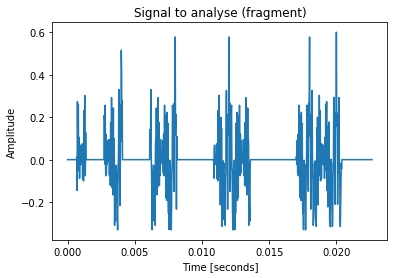

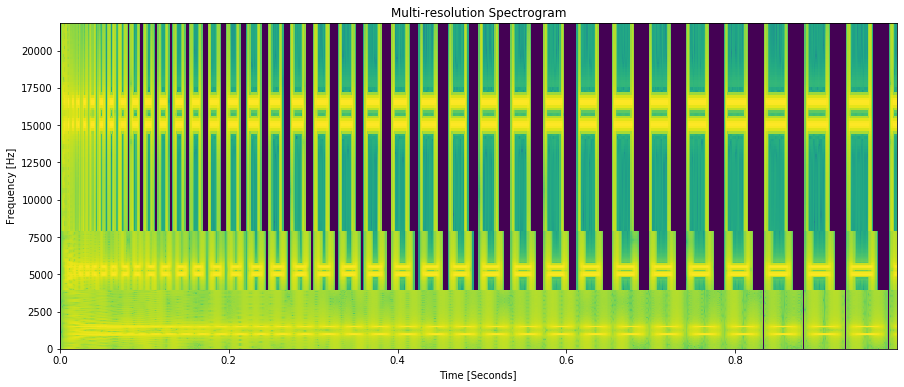

In [5]:
# sine generator
def gen_sine(A, f, phi, fs, t):
    x = np.zeros(fs*t)
    for Amp, freq, ph in zip(A,f,phi):
        n = np.arange(fs*t)
        x += Amp * np.cos(2*np.pi*freq*n/fs + ph)
    return x

# generating and summing 6 sine waves with amplitudes A and frequencies f
x = gen_sine(A = np.repeat(0.1,6), f = [1000,1500,5000,5500,15000,16500], phi = np.repeat(0,6), fs = 44100, t = 1)

# playing the signal generated
print("Sum of sine waves with different frequencies")
ipd.display(ipd.Audio(data=x, rate=fs))

# amplitude modulation of the signal generated with a square wave of increasing period
count = 30
mask = []
while len(mask) < len(x):
    for i in range(count):
        mask.append(0)
    for i in range(count):
        mask.append(1)
    count += 30
mask = mask[:len(x)]
x_test = x * mask

# playing the test signal
print("Signal to analyse")
ipd.display(ipd.Audio(data=x_test, rate=fs))

# plotting the test signal
plt.plot(np.arange(len(x_test[:1000]))/fs,x_test[:1000] )
plt.title("Signal to analyse (fragment)")
plt.xlabel("Time [seconds]")
plt.ylabel("Amplitude")
plt.show()

# multiresolution sinusoidal analysis/synthesis
### set the parameters
input_file = '../sounds/piano.wav'
M = [1023, 511, 255]
N = 2**np.ceil(np.log2(M)).astype(int) # power of 2 bigger than M
t = -90
B = [4000, 8000, 22050]
window = ['hamming','blackman',"blackmanharris"]

# get a window for each value M
w = []
for w_size, window_type in zip(M,window):
    w.append( get_window(window_type, w_size) )
fs, x = UF.wavread(input_file) 

# Multi-resolution sine model
y , xmX = sineModelMultiRes(x_test, fs, w, N, t, B)

# plotting spectrogram of the test signal
numFrames = np.shape(xmX)[0]
H = np.min(N)//4
frmTime = H*np.arange(numFrames)/float(fs)
binFreq_bands = []
low_B = 0
for n, high_B in zip(N,B):
    low_Bb = int(low_B*float(n)/fs)                         # discrete low frequency boundary
    high_Bb = int(high_B*float(n)/fs)                       # discrete high frequency boundary
    binFreq = np.arange(n/2+1)*float(fs)/n
    binFreq_bands = np.concatenate((binFreq_bands, binFreq[low_Bb: high_Bb]), axis=None)
    low_B = high_B                                          # low frequency boundary
plt.figure(figsize=(15, 6))
plt.pcolormesh(frmTime, binFreq_bands, np.transpose(xmX)) 
plt.xlabel("Time [Seconds]")
plt.ylabel("Frequency [Hz]")
plt.title( "Multi-resolution Spectrogram" )
plt.show()